In [1]:
#Base Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre Processing Imports
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Model Building Imports
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, SimpleRNN ,LSTM, Embedding, Dropout, GRU  #Activation, Flatten, Input, GRU , Bidirectional#  concatenate, #GlobalMaxPooling1D, MaxPooling1D
#Model Evaluation imports
from sklearn import metrics
from sklearn.metrics import (classification_report,confusion_matrix , 
                             precision_recall_curve ,precision_score,recall_score , accuracy_score,SCORERS)


 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv('emotions_preprocessed.csv')

## Data Preprocessing

In [3]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def clean(df):
    
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df




  

In [4]:
df = clean(df)

In [5]:
X= df.text 
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.4, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)
#60/20/20 split used


In [6]:
X_train.head()

31795              there’s lot u lady here unfortunately 😔
6383                 i surprised see name towing line show
20664             name worse he’s thing plus took boi name
23929    probably would tell worry much wait bit try fe...
6505                                         you nailed it
Name: text, dtype: object

In [7]:
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [8]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(X_train)
#tokenizer.fit_on_texts(pd.concat([X_train], axis=0))

In [9]:
X_train

31795              there’s lot u lady here unfortunately 😔
6383                 i surprised see name towing line show
20664             name worse he’s thing plus took boi name
23929    probably would tell worry much wait bit try fe...
6505                                         you nailed it
                               ...                        
21563    how supposed get link first place site trustwo...
25916                                         ooo i go far
44824              at job i can do get laid lot second one
21618                               what word i m confused
23886               honestly that’s wife material get that
Name: text, Length: 32396, dtype: object

In [10]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [11]:
max_len = max([len(t) for t in X_train])
max_len

155

In [12]:
X_train = pad_sequences(sequences_train, maxlen = max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen = max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen = max_len, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 20642


In [13]:
np.unique(X_train)

array([    0,     2,     3, ..., 20639, 20640, 20641], dtype=int32)

## Text Representation Using Glove Embedding 

In [14]:
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0

In [15]:
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 8074 word vectors.
Converted 5106 words (15535 misses)


In [16]:
X_train.shape

(32396, 155)

In [17]:
y_train.shape

(32396, 14)

In [18]:
#use early stopping to control overfitting
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

## Simple RNN

In [19]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
rnn_model.add(SimpleRNN(units=64, return_sequences=True))
rnn_model.add(Dropout(0.5))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dropout(0.5))
rnn_model.add(Dense(14, activation='softmax'))
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 155, 300)          6192600   
                                                                 
 simple_rnn (SimpleRNN)      (None, 155, 64)           23360     
                                                                 
 dropout (Dropout)           (None, 155, 64)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 14)                462       
                                                                 
Total params: 6,219,526
Trainable params: 26,926
Non-tra

In [20]:
rnn_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [21]:
# Fit model
history_rnn=rnn_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
127/127 [==============================] - 49s 306ms/step - loss: 2.6291 - accuracy: 0.2060 - val_loss: 2.2951 - val_accuracy: 0.2997
Epoch 2/30
127/127 [==============================] - 40s 315ms/step - loss: 2.3864 - accuracy: 0.2828 - val_loss: 2.1779 - val_accuracy: 0.3385
Epoch 3/30
127/127 [==============================] - 39s 304ms/step - loss: 2.2217 - accuracy: 0.3418 - val_loss: 2.0948 - val_accuracy: 0.3589
Epoch 4/30
127/127 [==============================] - 38s 299ms/step - loss: 2.1477 - accuracy: 0.3633 - val_loss: 2.0946 - val_accuracy: 0.3596
Epoch 5/30
127/127 [==============================] - 39s 309ms/step - loss: 2.1129 - accuracy: 0.3725 - val_loss: 2.0740 - val_accuracy: 0.3717
Epoch 6/30
127/127 [==============================] - 39s 305ms/step - loss: 2.0665 - accuracy: 0.3860 - val_loss: 2.0155 - val_accuracy: 0.3946
Epoch 7/30
127/127 [==============================] - 38s 299ms/step - loss: 2.0528 - accuracy: 0.3939 - val_loss: 1.9979 - val_ac

In [22]:
rnn_y_pred = rnn_model.predict(X_test)
rnn_y_pred_labels = np.argmax(rnn_y_pred, axis=1)
rnn_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(rnn_y_test_labels, rnn_y_pred_labels))

338/338 [==============================] - 10s 28ms/step
              precision    recall  f1-score   support

           0       0.39      0.90      0.55      3147
           1       0.00      0.00      0.00       798
           2       0.00      0.00      0.00       367
           3       0.33      0.05      0.08       243
           4       0.00      0.00      0.00       688
           5       0.47      0.56      0.51      1010
           6       0.00      0.00      0.00       243
           7       0.73      0.86      0.79       557
           8       0.43      0.18      0.26       781
           9       0.26      0.37      0.31       333
          10       0.50      0.31      0.39       592
          11       0.00      0.00      0.00       923
          12       0.00      0.00      0.00       537
          13       0.53      0.51      0.52       580

    accuracy                           0.43     10799
   macro avg       0.26      0.27      0.24     10799
weighted avg       0.30

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


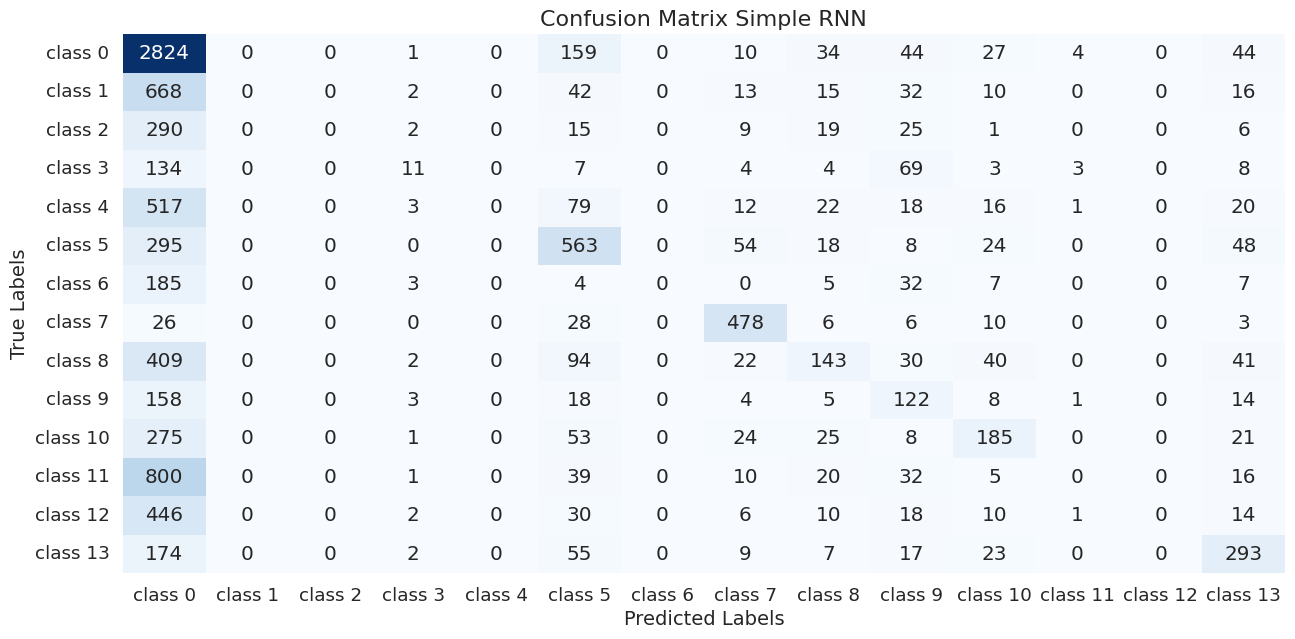

In [23]:
conf_mat_rnn = confusion_matrix(rnn_y_test_labels, rnn_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_rnn, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Simple RNN', fontsize=16)
plt.show()

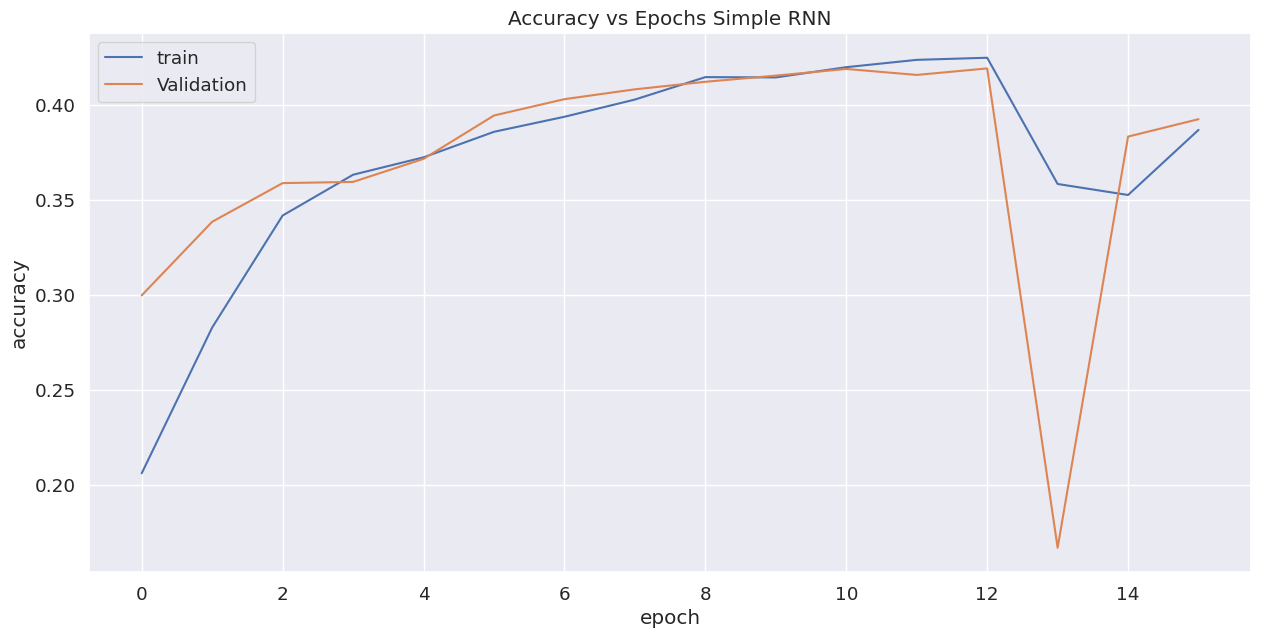

In [24]:
plt.figure(figsize=(15,7))
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Accuracy vs Epochs Simple RNN')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

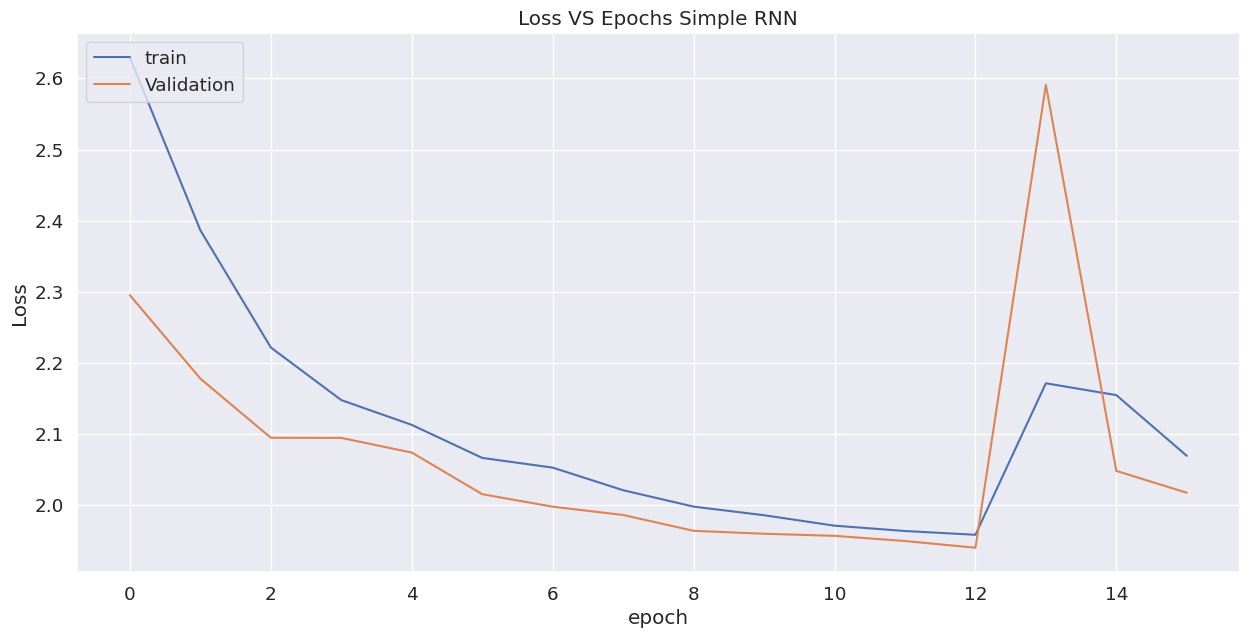

In [25]:
plt.figure(figsize=(15,7))
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Loss VS Epochs Simple RNN')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## LSTM MODEL

In [26]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(units=64, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(14, activation='softmax'))
lstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 155, 300)          6192600   
                                                                 
 lstm (LSTM)                 (None, 155, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 155, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                462       
                                                                 
Total params: 6,298,918
Trainable params: 106,318
Non-

In [27]:
lstm_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [28]:
# Fit model
history_lstm=lstm_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
127/127 [==============================] - 9s 31ms/step - loss: 2.3150 - accuracy: 0.3091 - val_loss: 2.1228 - val_accuracy: 0.3640
Epoch 2/30
127/127 [==============================] - 3s 24ms/step - loss: 2.0699 - accuracy: 0.3933 - val_loss: 1.9659 - val_accuracy: 0.4116
Epoch 3/30
127/127 [==============================] - 3s 24ms/step - loss: 1.9727 - accuracy: 0.4228 - val_loss: 1.9121 - val_accuracy: 0.4241
Epoch 4/30
127/127 [==============================] - 3s 22ms/step - loss: 1.9249 - accuracy: 0.4343 - val_loss: 1.8773 - val_accuracy: 0.4299
Epoch 5/30
127/127 [==============================] - 3s 24ms/step - loss: 1.8906 - accuracy: 0.4439 - val_loss: 1.8493 - val_accuracy: 0.4415
Epoch 6/30
127/127 [==============================] - 3s 24ms/step - loss: 1.8615 - accuracy: 0.4507 - val_loss: 1.8398 - val_accuracy: 0.4420
Epoch 7/30
127/127 [==============================] - 3s 25ms/step - loss: 1.8404 - accuracy: 0.4542 - val_loss: 1.8177 - val_accuracy: 0.4503

In [29]:
lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_labels = np.argmax(lstm_y_pred, axis=1)
lstm_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(lstm_y_test_labels, lstm_y_pred_labels))

338/338 [==============================] - 3s 6ms/step
              precision    recall  f1-score   support

           0       0.43      0.84      0.57      3147
           1       0.44      0.21      0.29       798
           2       0.48      0.22      0.30       367
           3       0.49      0.25      0.33       243
           4       0.53      0.09      0.15       688
           5       0.59      0.55      0.57      1010
           6       0.45      0.16      0.23       243
           7       0.78      0.85      0.82       557
           8       0.54      0.29      0.38       781
           9       0.36      0.36      0.36       333
          10       0.54      0.43      0.48       592
          11       0.34      0.14      0.20       923
          12       0.23      0.02      0.04       537
          13       0.53      0.57      0.55       580

    accuracy                           0.48     10799
   macro avg       0.48      0.35      0.38     10799
weighted avg       0.47  

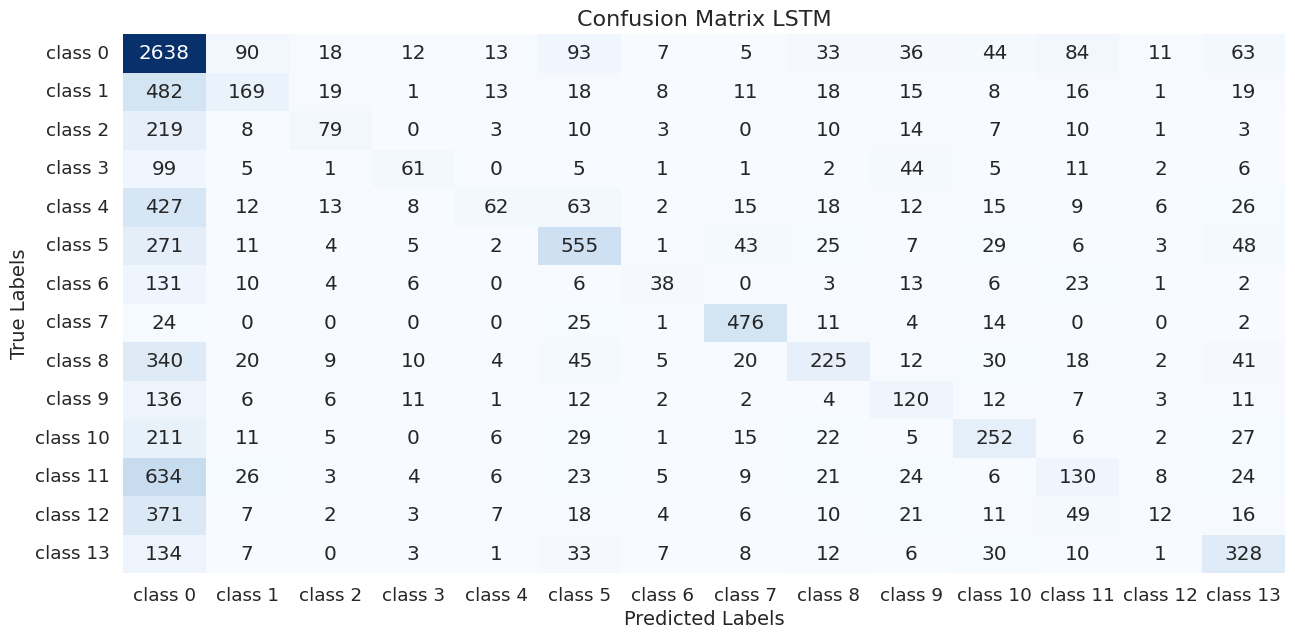

In [30]:
conf_mat_lstm = confusion_matrix(lstm_y_test_labels, lstm_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix LSTM', fontsize=16)
plt.show()

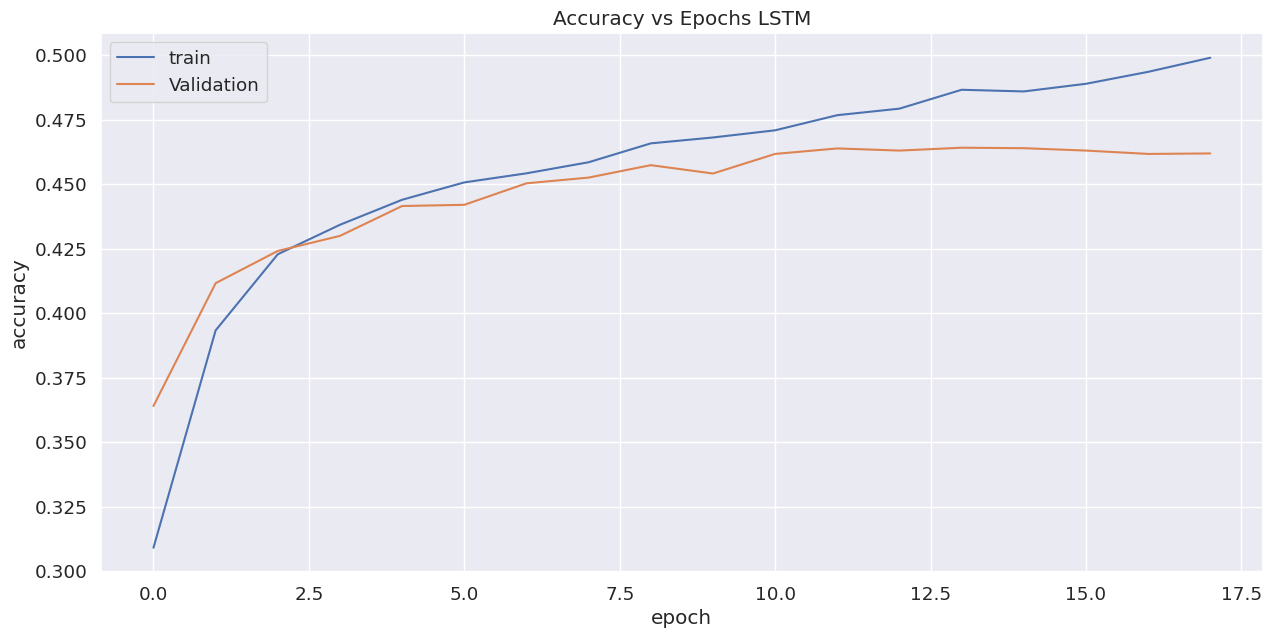

In [31]:
plt.figure(figsize=(15,7))
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Accuracy vs Epochs LSTM')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

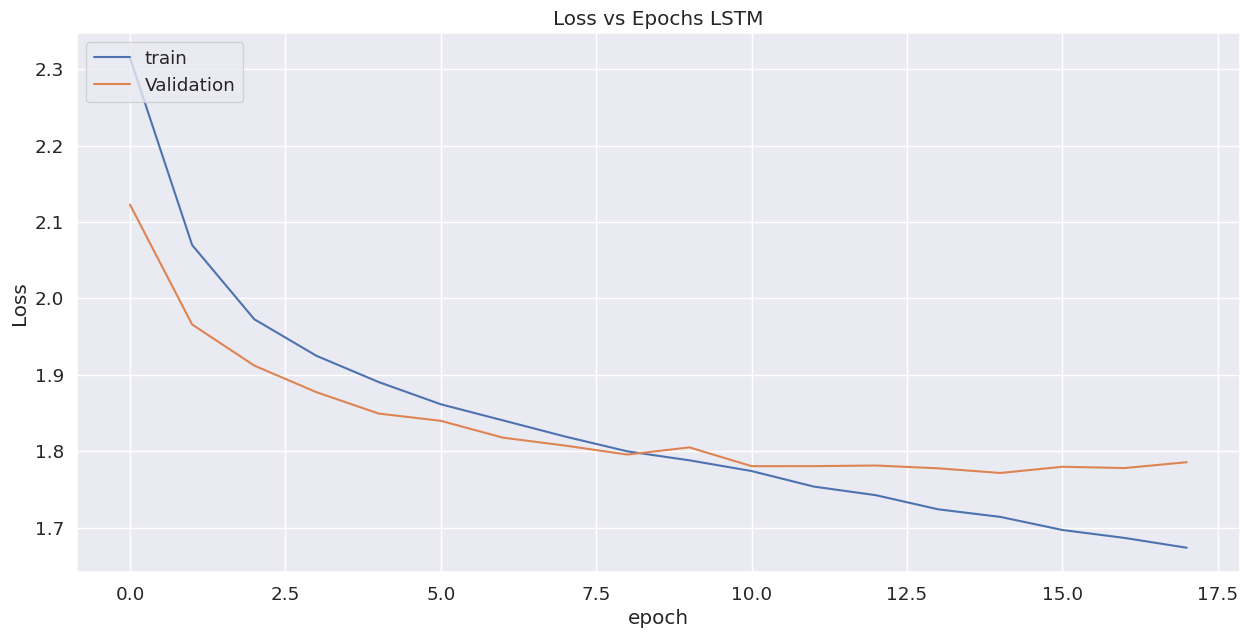

In [32]:
plt.figure(figsize=(15,7))
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Loss vs Epochs LSTM')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Gated Recurrent Unit (GRU)

In [33]:
gru_model = Sequential()
gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(units=32))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(14, activation='softmax'))
gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 155, 300)          6192600   
                                                                 
 gru (GRU)                   (None, 155, 64)           70272     
                                                                 
 dropout_4 (Dropout)         (None, 155, 64)           0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                462       
                                                                 
Total params: 6,272,742
Trainable params: 80,142
Non-t

In [34]:
gru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [35]:
# Fit model
history_gru=gru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
127/127 [==============================] - 7s 27ms/step - loss: 2.2912 - accuracy: 0.3238 - val_loss: 2.0435 - val_accuracy: 0.3900
Epoch 2/30
127/127 [==============================] - 3s 24ms/step - loss: 2.0358 - accuracy: 0.4030 - val_loss: 1.9425 - val_accuracy: 0.4211
Epoch 3/30
127/127 [==============================] - 3s 23ms/step - loss: 1.9559 - accuracy: 0.4264 - val_loss: 1.8913 - val_accuracy: 0.4349
Epoch 4/30
127/127 [==============================] - 3s 21ms/step - loss: 1.9136 - accuracy: 0.4414 - val_loss: 1.8558 - val_accuracy: 0.4448
Epoch 5/30
127/127 [==============================] - 3s 21ms/step - loss: 1.8843 - accuracy: 0.4481 - val_loss: 1.8324 - val_accuracy: 0.4526
Epoch 6/30
127/127 [==============================] - 3s 23ms/step - loss: 1.8520 - accuracy: 0.4523 - val_loss: 1.8050 - val_accuracy: 0.4554
Epoch 7/30
127/127 [==============================] - 3s 21ms/step - loss: 1.8272 - accuracy: 0.4591 - val_loss: 1.7996 - val_accuracy: 0.4567

In [36]:
gru_y_pred = gru_model.predict(X_test)
gru_y_pred_labels = np.argmax(gru_y_pred, axis=1)
gru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(gru_y_test_labels, gru_y_pred_labels))

338/338 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.43      0.85      0.57      3147
           1       0.45      0.23      0.31       798
           2       0.49      0.19      0.27       367
           3       0.53      0.28      0.36       243
           4       0.55      0.12      0.19       688
           5       0.58      0.57      0.58      1010
           6       0.45      0.15      0.23       243
           7       0.80      0.85      0.82       557
           8       0.52      0.32      0.40       781
           9       0.43      0.33      0.38       333
          10       0.61      0.39      0.47       592
          11       0.37      0.14      0.20       923
          12       0.24      0.01      0.03       537
          13       0.53      0.56      0.55       580

    accuracy                           0.48     10799
   macro avg       0.50      0.36      0.38     10799
weighted avg       0.48  

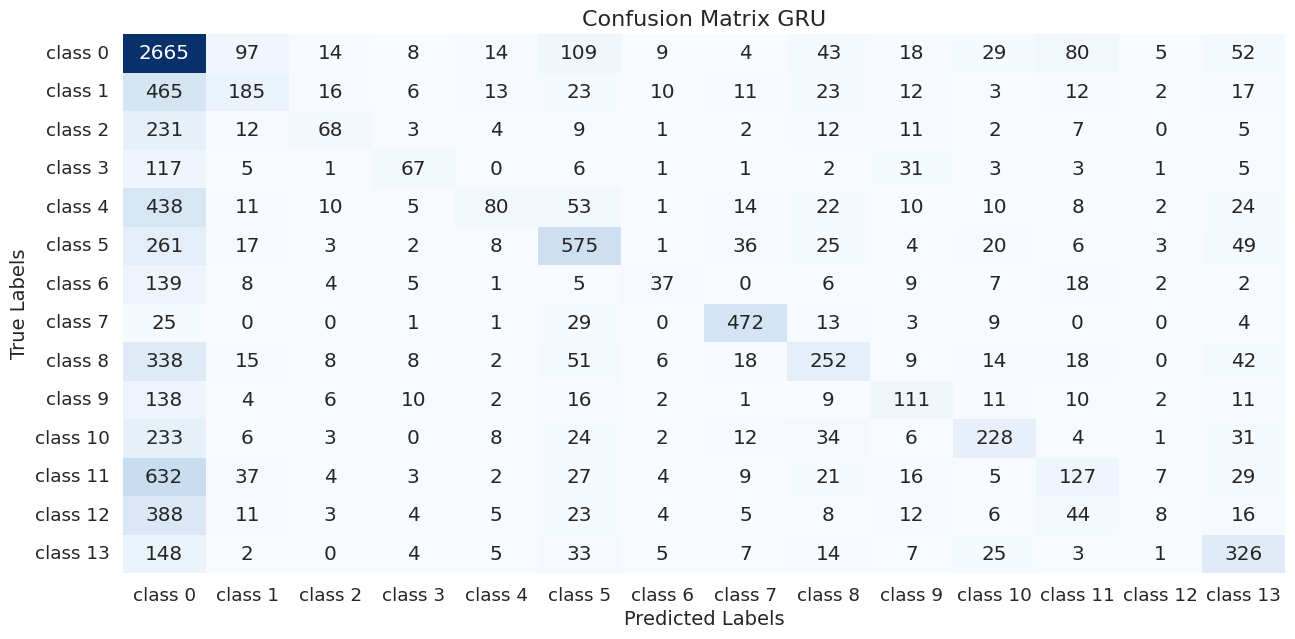

In [37]:
conf_mat_gru = confusion_matrix(gru_y_test_labels, gru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_gru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix GRU', fontsize=16)
plt.show()

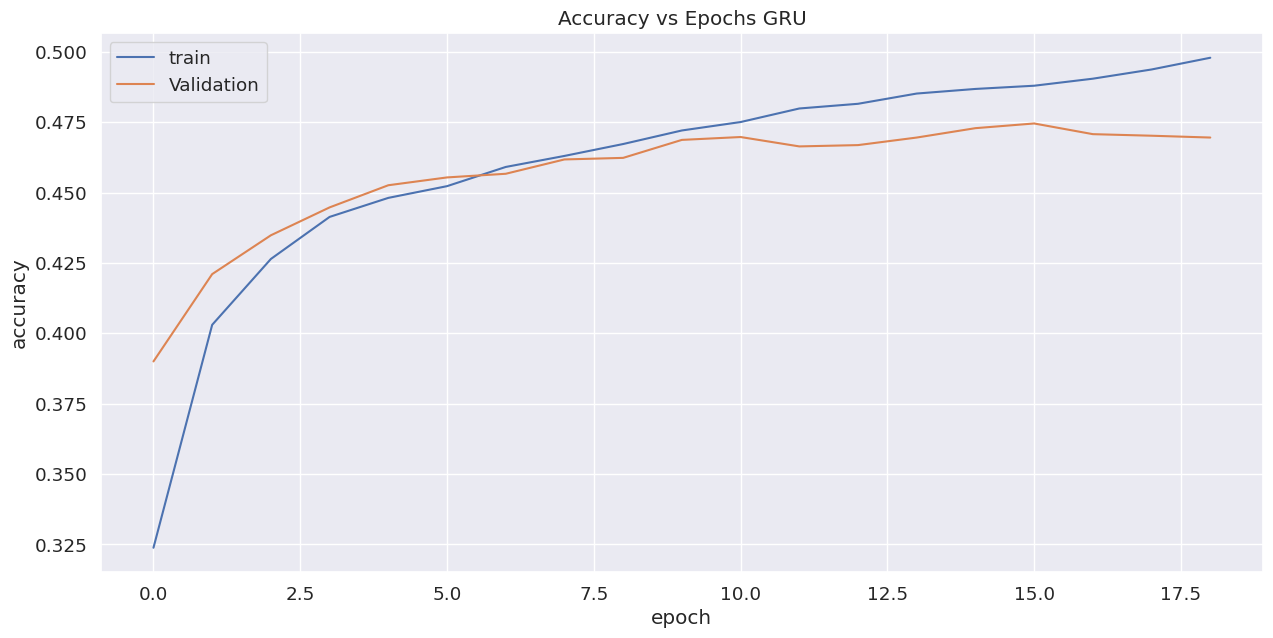

In [38]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['accuracy'])
plt.plot(history_gru.history['val_accuracy'])
plt.title('Accuracy vs Epochs GRU')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

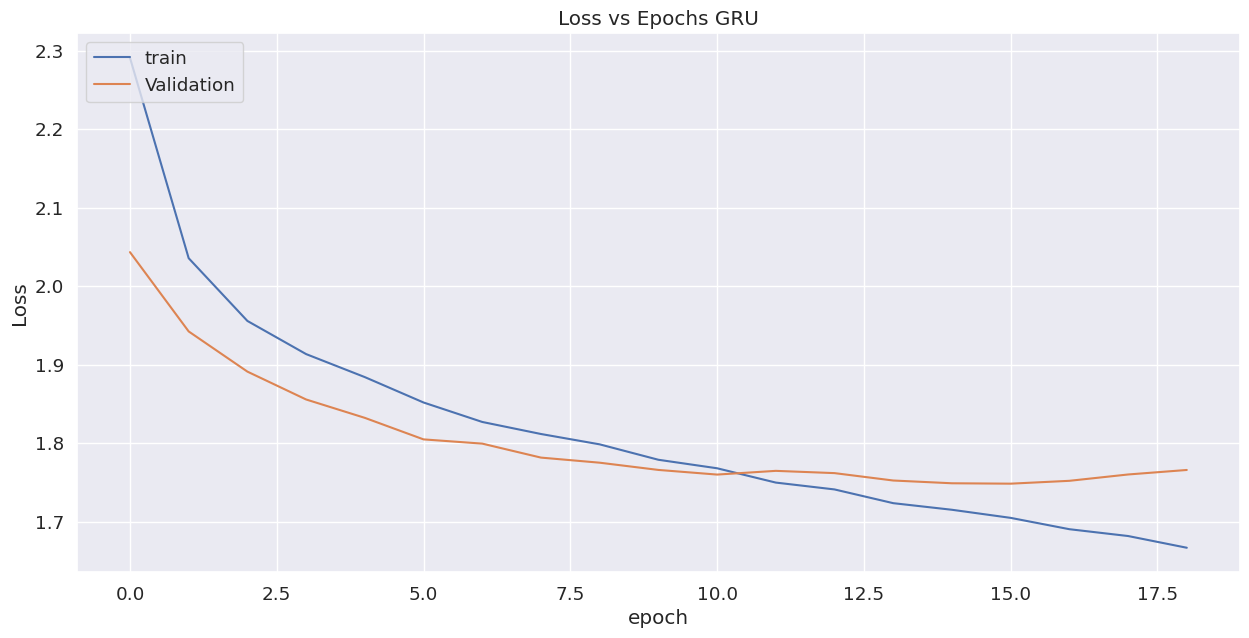

In [39]:
plt.figure(figsize=(15,7))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Loss vs Epochs GRU')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## LSTM With GRU Layers

In [40]:
lstmgru_model = Sequential()
lstmgru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
lstmgru_model.add(LSTM(units=64, return_sequences=True))
lstmgru_model.add(Dropout(0.5))
lstmgru_model.add(GRU(units=32))
lstmgru_model.add(Dropout(0.5))
lstmgru_model.add(Dense(14, activation='softmax'))
lstmgru_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 155, 300)          6192600   
                                                                 
 lstm_2 (LSTM)               (None, 155, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 155, 64)           0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 14)                462       
                                                                 
Total params: 6,295,910
Trainable params: 103,310
Non-

In [41]:
lstmgru_model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

In [42]:
# Fit model
history_lstmgru=lstmgru_model.fit(X_train,
            y_train,
            validation_data=(X_val, y_val),
            verbose=1,
            batch_size=256,
            epochs=30,
            callbacks=[callback]
        )

Epoch 1/30
127/127 [==============================] - 8s 32ms/step - loss: 2.2739 - accuracy: 0.3294 - val_loss: 2.0342 - val_accuracy: 0.3887
Epoch 2/30
127/127 [==============================] - 3s 22ms/step - loss: 2.0292 - accuracy: 0.4061 - val_loss: 1.9280 - val_accuracy: 0.4211
Epoch 3/30
127/127 [==============================] - 3s 25ms/step - loss: 1.9461 - accuracy: 0.4289 - val_loss: 1.8883 - val_accuracy: 0.4370
Epoch 4/30
127/127 [==============================] - 3s 24ms/step - loss: 1.9063 - accuracy: 0.4383 - val_loss: 1.8699 - val_accuracy: 0.4399
Epoch 5/30
127/127 [==============================] - 3s 25ms/step - loss: 1.8798 - accuracy: 0.4420 - val_loss: 1.8395 - val_accuracy: 0.4452
Epoch 6/30
127/127 [==============================] - 3s 25ms/step - loss: 1.8534 - accuracy: 0.4525 - val_loss: 1.8246 - val_accuracy: 0.4487
Epoch 7/30
127/127 [==============================] - 3s 22ms/step - loss: 1.8298 - accuracy: 0.4582 - val_loss: 1.8083 - val_accuracy: 0.4518

In [43]:
lstmgru_y_pred = lstmgru_model.predict(X_test)
lstmgru_y_pred_labels = np.argmax(lstmgru_y_pred, axis=1)
lstmgru_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(lstmgru_y_test_labels, lstmgru_y_pred_labels))

338/338 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.42      0.84      0.56      3147
           1       0.42      0.25      0.31       798
           2       0.50      0.19      0.27       367
           3       0.52      0.24      0.33       243
           4       0.51      0.11      0.18       688
           5       0.61      0.55      0.58      1010
           6       0.53      0.12      0.19       243
           7       0.79      0.83      0.81       557
           8       0.57      0.32      0.41       781
           9       0.42      0.30      0.35       333
          10       0.61      0.40      0.48       592
          11       0.30      0.15      0.20       923
          12       0.17      0.01      0.03       537
          13       0.55      0.55      0.55       580

    accuracy                           0.48     10799
   macro avg       0.50      0.35      0.38     10799
weighted avg       0.48  

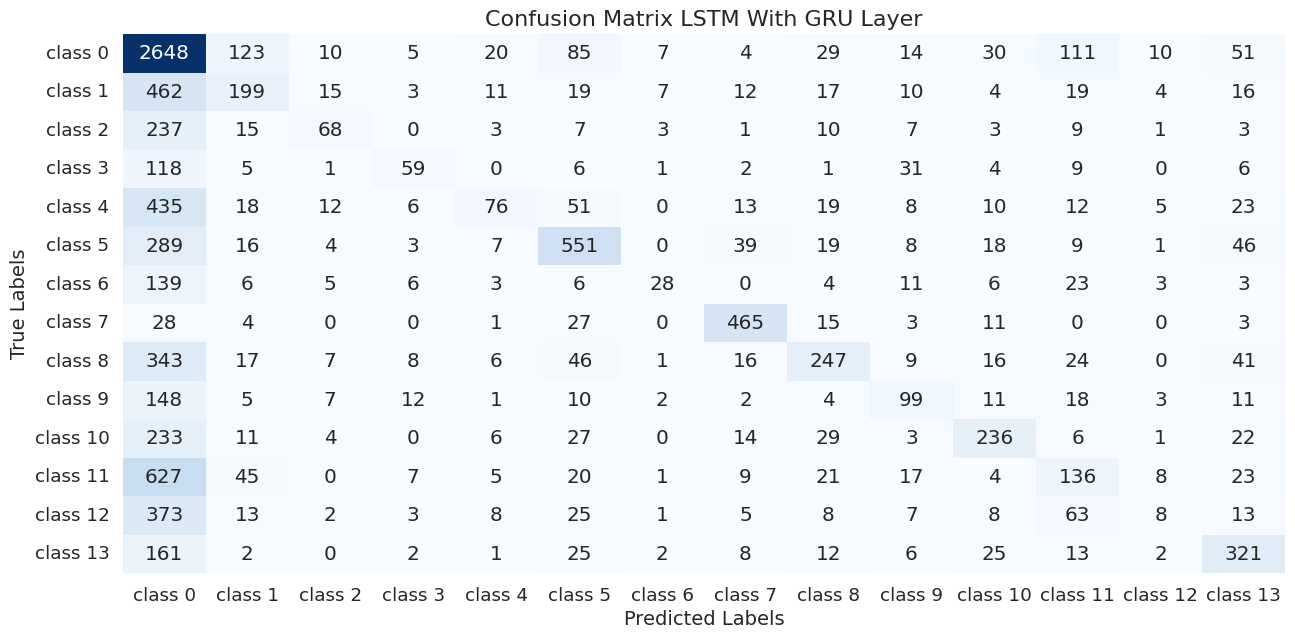

In [44]:
conf_mat_lstmgru = confusion_matrix(lstmgru_y_test_labels, lstmgru_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_lstmgru, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix LSTM With GRU Layer', fontsize=16)
plt.show()

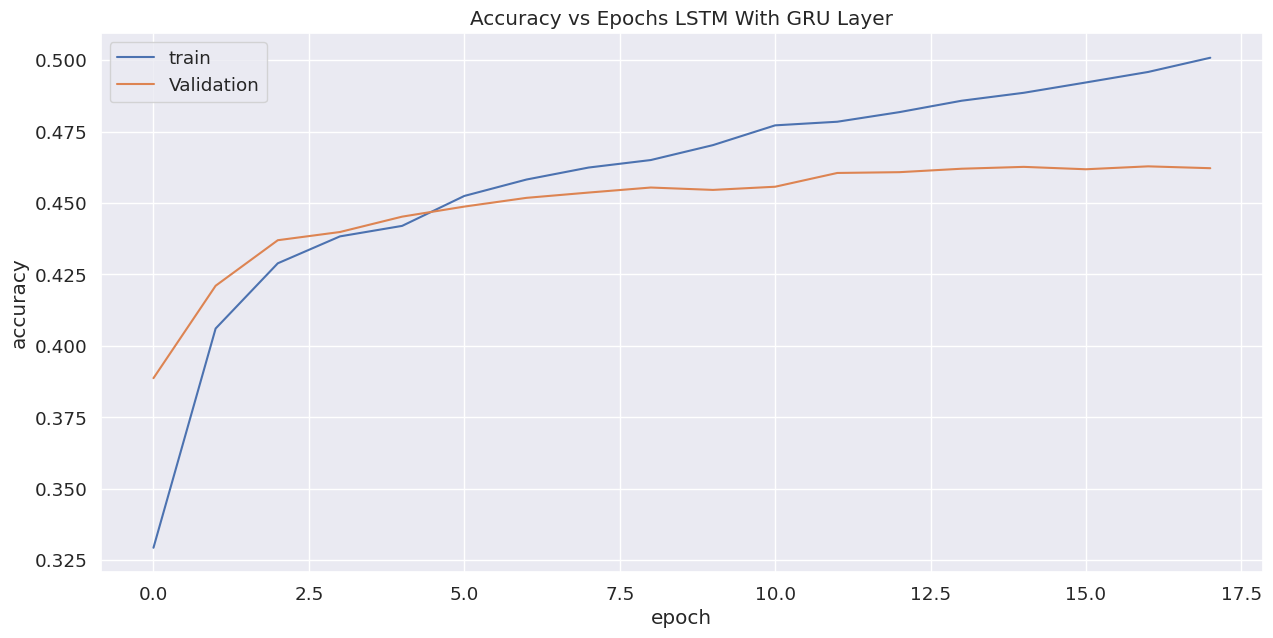

In [45]:
plt.figure(figsize=(15,7))
plt.plot(history_lstmgru.history['accuracy'])
plt.plot(history_lstmgru.history['val_accuracy'])
plt.title('Accuracy vs Epochs LSTM With GRU Layer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

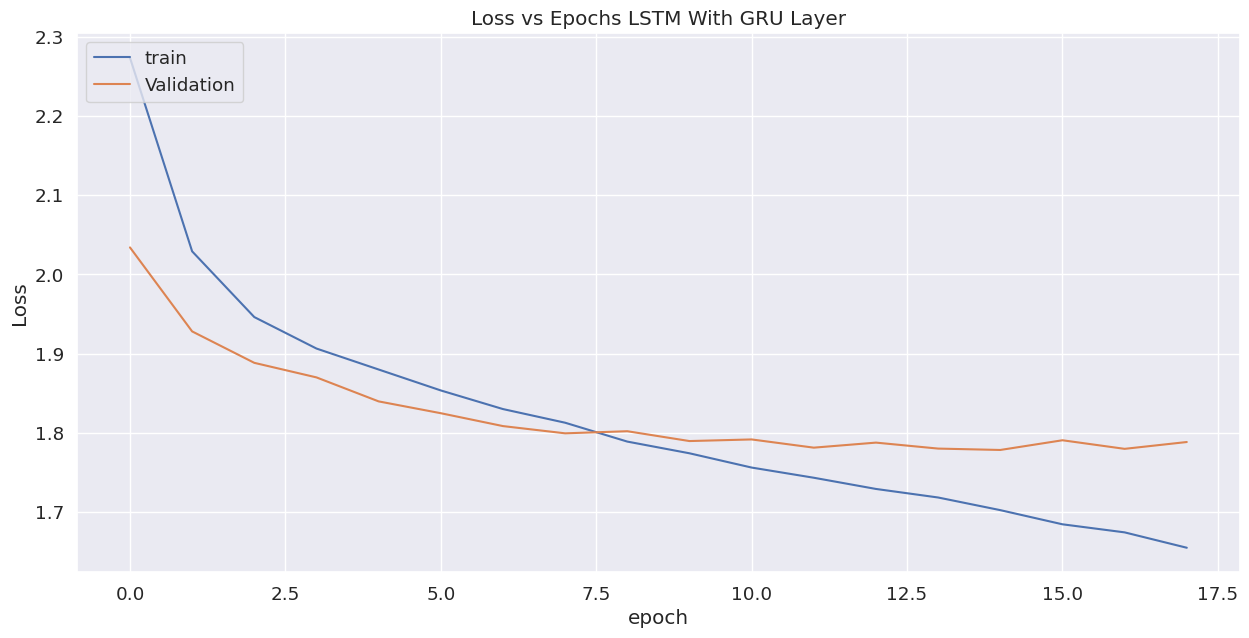

In [46]:
plt.figure(figsize=(15,7))
plt.plot(history_lstmgru.history['loss'])
plt.plot(history_lstmgru.history['val_loss'])
plt.title('Loss vs Epochs LSTM With GRU Layer')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()